# Data Preparation

In [1]:
#Check requirements.txt for the version of the libraries.
import pandas as pd
import os
import spacy
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\crout\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Example of pre-processing on a User Story

In [2]:
user_story = "As a site member, I want to access to the Facebook profiles of other members so that I can share my experiences with them."
print(user_story)

As a site member, I want to access to the Facebook profiles of other members so that I can share my experiences with them.


#### Privacy categories and words extraction

In [3]:
from Privacy_Dictionary.liwc_class import Liwc
dictionary = Liwc('Privacy_Dictionary/privacydictionary_TAWC.dic')
c,k = dictionary.parse(user_story.lower().split(' '))
categories = [list(i) for i in c.items()]
print(categories)
print(k)

[['OpenVisible', 2]]
['access', 'share']


#### Enities, dependencies and parts of speech extraction

In [4]:
from spacy import displacy
nlp = spacy.load('Disclosure_NER')
doc = nlp(u"As a site member, I want to access to the Facebook profiles of other members so that I can share my experiences with them.")
displacy.render(doc, style='ent', jupyter=True)
displacy.render(doc, style='dep', jupyter=True)

In [5]:
from tabulate import tabulate
from string import punctuation
data = [] 
for token in doc:
    if str(token) not in punctuation:
        data.append([token.text, token.pos_, token.dep_])

print (tabulate(data, headers=["Text", "Part of speech", "Dependency"]))

Text         Part of speech    Dependency
-----------  ----------------  ------------
As           SCONJ             prep
a            DET               det
site         NOUN              compound
member       NOUN              pobj
I            PRON              nsubj
want         VERB              ROOT
to           PART              aux
access       VERB              xcomp
to           ADP               prep
the          DET               det
Facebook     PROPN             compound
profiles     NOUN              pobj
of           ADP               prep
other        ADJ               amod
members      NOUN              pobj
so           SCONJ             mark
that         SCONJ             mark
I            PRON              nsubj
can          VERB              aux
share        VERB              advcl
my           DET               poss
experiences  NOUN              dobj
with         ADP               prep
them         PRON              pobj


#### Features extraction function

In [6]:
def extract_features(user_story):
    PERSONS = ['I', 'ME', 'MY', 'MINE', 'YOU', 'YOUR', 'YOURS', 'HE', 'SHE', 
           'HIS', 'HER', 'HIM', 'THEY', 'THEM', 'THEMSELVES', 'OUR', 'WE']
    LOCATION = ['LOC', 'GPE', 'ORG', 'FAC', 'CARDINAL']
    ALL_ENTITIES = LOCATION + ['PERSON', 'HEALTH', 'MONEY', 'DATE', 'TIME']
    
    doc = nlp(u''+user_story)

    modified_tokens = []
    modified_tokens_dep = []
    modified_tokens_pos = []
        
    for t in doc:
        if str(t) not in punctuation:
            if t.ent_type_ == '':
                if t.text.upper() in PERSONS:
                    modified_tokens.append('PERSON')
                else:
                    modified_tokens.append(t.text)
            else:
                modified_tokens.append(t.ent_type_)
    
    for t in doc:
        if str(t) not in punctuation:
            modified_tokens_dep.append(t.dep_)
 
    for t in doc:
        if str(t) not in punctuation:
            modified_tokens_pos.append(t.pos_)
    
    c,keywords = dictionary.parse(user_story.lower().split(' '))
    categories_list = [list(i) for i in c.items()]
    if str(keywords) == "[]":
        keywords = "none"
        categories_list = "none"

    return modified_tokens, modified_tokens_dep, modified_tokens_pos, categories_list, keywords

In [7]:
user_story = "As a site member, I want to access to the Facebook profiles of other members so that I can share my experiences with them."
print(user_story)
entities, dependecies, pos, categories, privacy_words = extract_features(user_story)
print(entities)
print(dependecies)
print(pos)
print(categories)
print(str(privacy_words))

As a site member, I want to access to the Facebook profiles of other members so that I can share my experiences with them.
['As', 'a', 'site', 'member', 'PERSON', 'want', 'to', 'access', 'to', 'the', 'ORG', 'profiles', 'of', 'other', 'members', 'so', 'that', 'PERSON', 'can', 'share', 'PERSON', 'experiences', 'with', 'PERSON']
['prep', 'det', 'compound', 'pobj', 'nsubj', 'ROOT', 'aux', 'xcomp', 'prep', 'det', 'compound', 'pobj', 'prep', 'amod', 'pobj', 'mark', 'mark', 'nsubj', 'aux', 'advcl', 'poss', 'dobj', 'prep', 'pobj']
['SCONJ', 'DET', 'NOUN', 'NOUN', 'PRON', 'VERB', 'PART', 'VERB', 'ADP', 'DET', 'PROPN', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'SCONJ', 'SCONJ', 'PRON', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'PRON']
[['OpenVisible', 2]]
['access', 'share']


#### Loading Disclosure CNN model and its tokenizer

In [8]:
# loading Disclosure neural network
from tensorflow import keras
disclosure_cnn = keras.models.load_model('Disclosure_CNN/cnn.h5')

# loading tokenizer for the Disclosure neural network
with open('Disclosure_CNN/transformer.pickle', 'rb') as handle:
    transformer = pickle.load(handle)

##### Encoding features function

In [9]:
def encode_features(entities, dependecies, pos, categories, privacy_words):
    
    max_length = 558
    
    #Encoding entities
    encoded1 = np.zeros((1,max_length))
    count=0
    for i in transformer.texts_to_sequences(entities):
        if len(i) >0:
            encoded1[0,count]=int(i[0])
        count+=1
    
    
    #Encoding dependencies
    encoded2 = np.zeros((1,max_length))
    count=0
    for i in transformer.texts_to_sequences(dependecies):
        if len(i) >0:
            encoded2[0,count]=int(i[0])
        count+=1
    
    
    #Encoding parts of speech
    encoded3 = np.zeros((1,max_length))
    count=0
    for i in transformer.texts_to_sequences(pos):
        if len(i) >0:
            encoded3[0,count]=int(i[0])
        count+=1

    #Encoding privacy categories
    encoded4 = np.zeros((1,max_length))
    count=0
    for i in transformer.texts_to_sequences(str(categories)):
        if len(i) >0:
            encoded4[0,count]=int(i[0])
        count+=1
    
    #Encoding privacy words
    encoded5 = np.zeros((1,max_length))
    count=0
    for i in transformer.texts_to_sequences(str(privacy_words)):
        if len(i) >0:
            encoded5[0,count]=int(i[0])
        count+=1

    return encoded1, encoded2, encoded3, encoded4, encoded5    

In [10]:
entities_enc, dependecies_enc, pos_enc, categories_enc, privacy_words_enc = encode_features(entities, dependecies, pos, categories, privacy_words)
print(entities_enc)
print(dependecies_enc)
print(pos_enc)
print(categories_enc)
print(privacy_words_enc)

[[6.700e+01 3.200e+01 4.075e+03 0.000e+00 1.000e+00 1.010e+02 2.600e+01
  1.362e+03 2.600e+01 3.300e+01 1.630e+02 0.000e+00 3.700e+01 1.710e+02
  9.080e+02 6.100e+01 4.000e+01 1.000e+00 9.200e+01 6.740e+02 1.000e+00
  5.080e+03 4.900e+01 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.

#### Getting the output of Disclosure CNN model

In [11]:
disclosure_cnn.predict([entities_enc, dependecies_enc, pos_enc])

array([[1.]], dtype=float32)

## Example of features extraction on a dataset

In [12]:
us_example = pd.read_csv("US_Dataset/g02-federalspending.txt",dtype=object, sep="\n", header=None)
print(us_example.head())
print(us_example.columns)

                                                   0
0  As a Data user, I want to have the 12-19-2017 ...
1  As a UI designer, I want to redesign the Resou...
2  As a UI designer, I want to report to the Agen...
3  As a UI designer, I want to move on to round 2...
4  As a UI designer, I want to move on to round 2...
Int64Index([0], dtype='int64')


In [13]:
us_example = us_example.rename(columns={0: "User Story"})
print(us_example.head())
print(us_example.columns)

                                          User Story
0  As a Data user, I want to have the 12-19-2017 ...
1  As a UI designer, I want to redesign the Resou...
2  As a UI designer, I want to report to the Agen...
3  As a UI designer, I want to move on to round 2...
4  As a UI designer, I want to move on to round 2...
Index(['User Story'], dtype='object')


In [14]:
us_example["Entities"] = None
us_example["Dependencies"] = None
us_example["Parts of Speech"] = None
us_example["Privacy Categories"] = None
us_example["Privacy Words"] = None
us_example["Disclosure?"] = None
counter = 0
for us in us_example["User Story"]:
    
    entities, dependecies, pos, categories, privacy_words = extract_features(us)
    us_example.loc[counter,"Entities"] = entities
    us_example.loc[counter,"Dependencies"] = dependecies
    us_example.loc[counter,"Parts of Speech"] = pos
    us_example.loc[counter,"Privacy Categories"] = categories
    us_example.loc[counter,"Privacy Words"] = privacy_words
    
    entities_enc, dependecies_enc, pos_enc, categories_enc, privacy_words_enc = encode_features(entities, dependecies, pos, categories, privacy_words)
    x = disclosure_cnn.predict([entities_enc, dependecies_enc, pos_enc])
    if x > 0.5:
        us_example.loc[counter,"Disclosure?"] = 1
    else:
        us_example.loc[counter,"Disclosure?"] = 0
    
    
    counter+=1

us_example

,User Story,Entities,Dependencies,Parts of Speech,Privacy Categories,Privacy Words,Disclosure?
0,"As a Data user, I want to have the 12-19-2017 ...","[As, a, Data, user, PERSON, want, to, have, th...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, AU...","[[PrivateSecret, 1]]",[data],0
1,"As a UI designer, I want to redesign the Resou...","[As, a, HEALTH, HEALTH, PERSON, want, to, rede...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,0
2,"As a UI designer, I want to report to the Agen...","[As, a, HEALTH, HEALTH, PERSON, want, to, repo...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...","[[OpenVisible, 1]]",[report],1
3,"As a UI designer, I want to move on to round 2...","[As, a, HEALTH, HEALTH, PERSON, want, to, move...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,1
4,"As a UI designer, I want to move on to round 2...","[As, a, HEALTH, HEALTH, PERSON, want, to, move...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,1
...,...,...,...,...,...,...,...
93,"As a FABS user, I want to have my validations ...","[As, a, FABS, user, PERSON, want, to, have, PE...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, AU...",none,none,1
94,"As a FABS user, I want to see correct status l...","[As, a, FABS, user, PERSON, want, to, see, cor...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,1
95,"As an agency user, I want to know when the sub...","[As, an, agency, user, PERSON, want, to, know,...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, NOUN, NOUN, PRON, VERB, PART, VER...",none,none,0
96,"As an agency user, I want a landing page to na...","[As, an, agency, user, PERSON, want, a, landin...","[prep, det, compound, pobj, nsubj, ROOT, det, ...","[SCONJ, DET, NOUN, NOUN, PRON, VERB, DET, NOUN...","[[OpenVisible, 1]]",[access],1


## Creating the full dataset containing extracted features

In [15]:
us_data = pd.DataFrame()

for file in os.listdir('./US_Dataset/'):
    print("Processing " + file + " ...")
    us_tmp = pd.read_csv('US_Dataset/'+file,dtype=object, sep="\n", header=None)
    us_tmp = us_tmp.rename(columns={0: "User Story"})
    us_tmp["Entities"] = None
    us_tmp["Dependencies"] = None
    us_tmp["Parts of Speech"] = None
    us_tmp["Privacy Categories"] = None
    us_tmp["Privacy Words"] = None
    us_tmp["Disclosure?"] = None
    counter = 0
    for us in us_tmp["User Story"]:
        
        entities, dependecies, pos, categories, privacy_words = extract_features(us)
        us_tmp.loc[counter,"Entities"] = entities
        us_tmp.loc[counter,"Dependencies"] = dependecies
        us_tmp.loc[counter,"Parts of Speech"] = pos
        us_tmp.loc[counter,"Privacy Categories"] = categories
        us_tmp.loc[counter,"Privacy Words"] = privacy_words
        
        entities_enc, dependecies_enc, pos_enc, categories_enc, privacy_words_enc = encode_features(entities, dependecies, pos, categories, privacy_words)
        x = disclosure_cnn.predict([entities_enc, dependecies_enc, pos_enc])
        if x > 0.5:
            us_tmp.loc[counter,"Disclosure?"] = 1
        else:
            us_tmp.loc[counter,"Disclosure?"] = 0
        
        counter+=1
    
    us_data = pd.concat([us_data, us_tmp])

us_data = us_data.reset_index(drop=True)
us_data

Processing g02-federalspending.txt ...
Processing g03-loudoun.txt ...
Processing g04-recycling.txt ...
Processing g05-openspending.txt ...
Processing g08-frictionless.txt ...
Processing g10-scrumalliance.txt ...
Processing g11-nsf.txt ...
Processing g12-camperplus.txt ...
Processing g13-planningpoker.txt ...
Processing g14-datahub.txt ...
Processing g16-mis.txt ...
Processing g17-cask.txt ...
Processing g18-neurohub.txt ...
Processing g19-alfred.txt ...
Processing g21-badcamp.txt ...
Processing g22-rdadmp.txt ...
Processing g23-archivesspace.txt ...
Processing g24-unibath.txt ...
Processing g25-duraspace.txt ...
Processing g26-racdam.txt ...
Processing g27-culrepo.txt ...
Processing g28-zooniverse.txt ...


,User Story,Entities,Dependencies,Parts of Speech,Privacy Categories,Privacy Words,Disclosure?
0,"As a Data user, I want to have the 12-19-2017 ...","[As, a, Data, user, PERSON, want, to, have, th...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, AU...","[[PrivateSecret, 1]]",[data],0
1,"As a UI designer, I want to redesign the Resou...","[As, a, HEALTH, HEALTH, PERSON, want, to, rede...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,0
2,"As a UI designer, I want to report to the Agen...","[As, a, HEALTH, HEALTH, PERSON, want, to, repo...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...","[[OpenVisible, 1]]",[report],1
3,"As a UI designer, I want to move on to round 2...","[As, a, HEALTH, HEALTH, PERSON, want, to, move...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,1
4,"As a UI designer, I want to move on to round 2...","[As, a, HEALTH, HEALTH, PERSON, want, to, move...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,1
...,...,...,...,...,...,...,...
1675,"As a Zooniverse admin, I want to know when Zoo...","[As, a, Zooniverse, admin, PERSON, want, to, k...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,1
1676,"As a Zooniverse admin, I want to know what Zoo...","[As, a, Zooniverse, admin, PERSON, want, to, k...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,1
1677,"As a Zooniverse admin, I want to group subject...","[As, a, Zooniverse, admin, PERSON, want, to, g...","[prep, det, compound, pobj, nsubj, ROOT, prep,...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...","[[Intimacy, 1]]",[group],0
1678,"As a Zooniverse admin, I want to recommend dif...","[As, a, Zooniverse, admin, PERSON, want, to, r...","[prep, det, compound, pobj, nsubj, ROOT, aux, ...","[SCONJ, DET, PROPN, NOUN, PRON, VERB, PART, VE...",none,none,0


#### Saving the full dataset

In [16]:
us_data.to_excel('US_dataset.xlsx',index=False)

# Data Exploration

According to the assumption explicated in the chapter "Approach", the following analysis was carried out.

##### User Stories containing privacy content

In [17]:
us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 2 to 1674
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   User Story          415 non-null    object
 1   Entities            415 non-null    object
 2   Dependencies        415 non-null    object
 3   Parts of Speech     415 non-null    object
 4   Privacy Categories  415 non-null    object
 5   Privacy Words       415 non-null    object
 6   Disclosure?         415 non-null    object
dtypes: object(7)
memory usage: 25.9+ KB


C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


##### User Stories that not contain privacy content

In [18]:
us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"]==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 1677
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   User Story          191 non-null    object
 1   Entities            191 non-null    object
 2   Dependencies        191 non-null    object
 3   Parts of Speech     191 non-null    object
 4   Privacy Categories  191 non-null    object
 5   Privacy Words       191 non-null    object
 6   Disclosure?         191 non-null    object
dtypes: object(7)
memory usage: 11.9+ KB


C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [19]:
us_data[us_data["Privacy Words"] == "none"][us_data["Disclosure?"]==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 644 entries, 3 to 1676
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   User Story          644 non-null    object
 1   Entities            644 non-null    object
 2   Dependencies        644 non-null    object
 3   Parts of Speech     644 non-null    object
 4   Privacy Categories  644 non-null    object
 5   Privacy Words       644 non-null    object
 6   Disclosure?         644 non-null    object
dtypes: object(7)
memory usage: 40.2+ KB


C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [20]:
us_data[us_data["Privacy Words"] == "none"][us_data["Disclosure?"]==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 1 to 1679
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   User Story          430 non-null    object
 1   Entities            430 non-null    object
 2   Dependencies        430 non-null    object
 3   Parts of Speech     430 non-null    object
 4   Privacy Categories  430 non-null    object
 5   Privacy Words       430 non-null    object
 6   Disclosure?         430 non-null    object
dtypes: object(7)
memory usage: 26.9+ KB


C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Visualizing data

#### Percentage of each type of US in the full dataset

C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


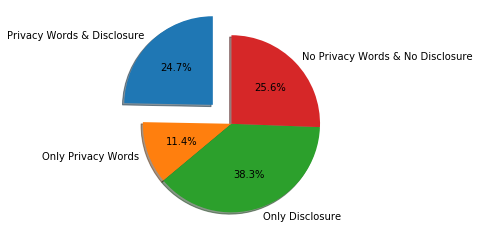

In [21]:
labels = 'Privacy Words & Disclosure', 'Only Privacy Words', 'Only Disclosure', 'No Privacy Words & No Disclosure'
sizes = [len(us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"]==1]),
         len(us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"]==0]),
         len(us_data[us_data["Privacy Words"] == "none"][us_data["Disclosure?"]==1]),
         len(us_data[us_data["Privacy Words"] == "none"][us_data["Disclosure?"]==0])]
explode = (0.3, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

#### How many of the User Stories containing privacy words also contain Disclosures?

C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


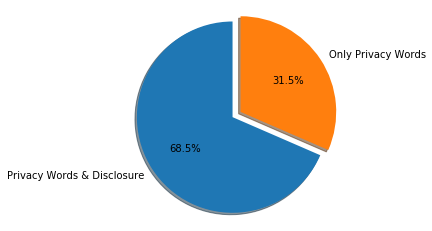

In [22]:
labels = 'Privacy Words & Disclosure', 'Only Privacy Words'
sizes = [len(us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"]==1]),
         len(us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"]==0])]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

#### How many of the User Stories containing Disclosure also contain privacy words?

C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


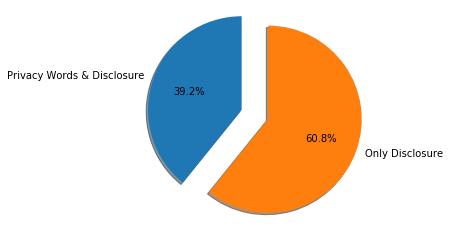

In [23]:
labels = 'Privacy Words & Disclosure', 'Only Disclosure'
sizes = [len(us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"]==1]),
         len(us_data[us_data["Privacy Words"] == "none"][us_data["Disclosure?"]==1])]
explode = (0.3, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### Privacy words analysis

In [24]:
bow = ""
for lists in us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"]==1]["Privacy Words"]:
    for words in lists:
        bow += words + " "

bow

C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


'report data data data access published data database ensure locked data track ensure publish ensure data ensure data data data access groups ensure access data access access data share prevent track ensure track publish report track ensure ensure ensure track ensure ensure track ensure track posted posted regulations ensure data anonymously access access data access access personal securely database identity password access concerns data publishing data publishing data data publishing delete data published delete data publishing data data data publishing data publishing data data data data publishing data data publishing data data data data publishing data data data data data publishing data data data data data data share share data data data share data data data data data publishing data data publishing hidden data publishing hide data publishing data publishing data community data open data publishing data publishing open data published accessible data data data data data data share

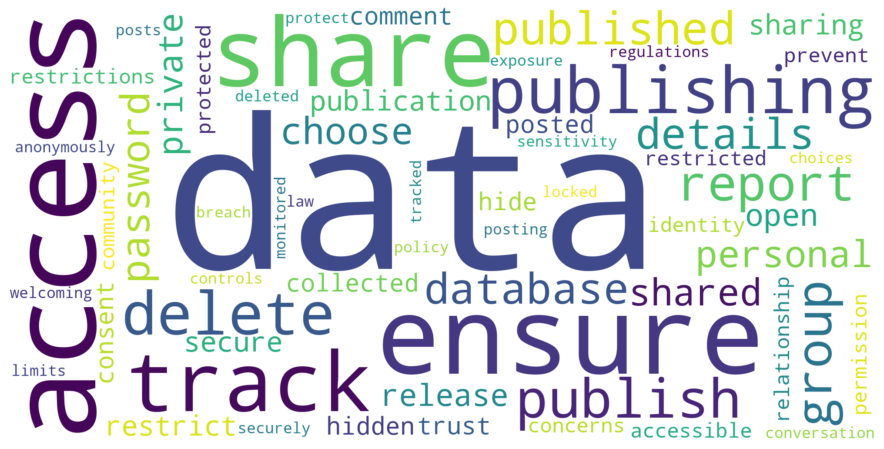

In [73]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 2000, height = 1000, collocations=False, background_color="white").generate(bow)

plt.figure(figsize=(32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

([<matplotlib.axis.YTick at 0x1a06d0d9208>,
 <a list of 10 Text yticklabel objects>)

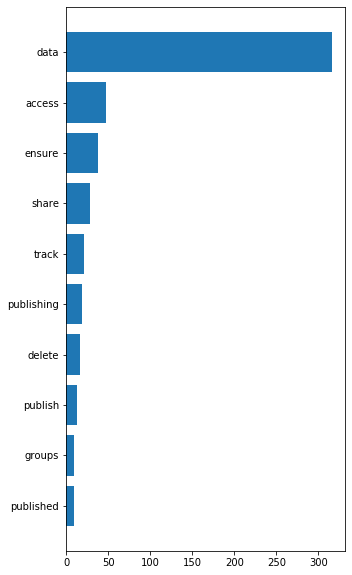

In [77]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()

X = vect.fit_transform(bow.lower().split(' '))

# zipping actual words and sum of their Tfidf for corpus
features_rank = list(zip(vect.get_feature_names(), [x[0] for x in X.sum(axis=0).T.tolist()]))

# sorting
features_rank = np.array(sorted(features_rank, key=lambda x:x[1], reverse=True))

n = 10
plt.figure(figsize=(5, 10))
plt.barh(-np.arange(n), features_rank[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=features_rank[:n, 0])

C:\Users\crout\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


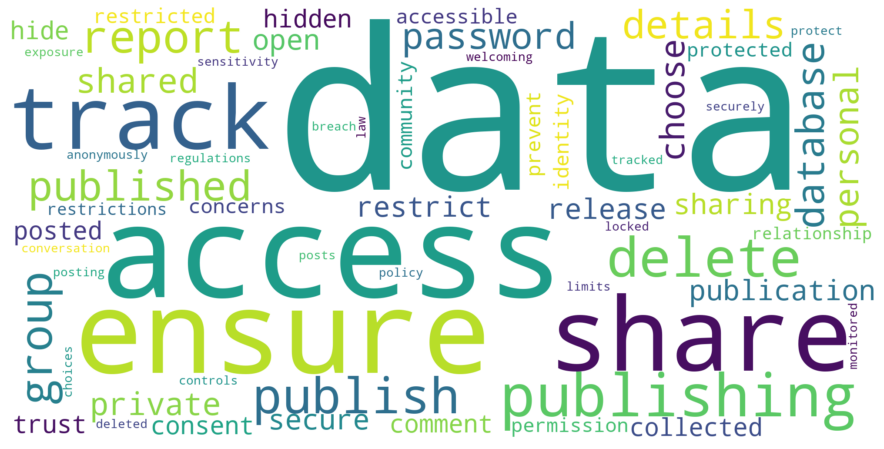

In [26]:
bow2 = ""
for lists in us_data[us_data["Privacy Words"] != "none"][us_data["Disclosure?"]==0]["Privacy Words"]:
    for words in lists:
        bow2 += words + " "

wordcloud = WordCloud(width = 2000, height = 1000, collocations=False, background_color="white").generate(bow)

plt.figure(figsize=(32,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

([<matplotlib.axis.YTick at 0x1a06cf34d08>,
 <a list of 10 Text yticklabel objects>)

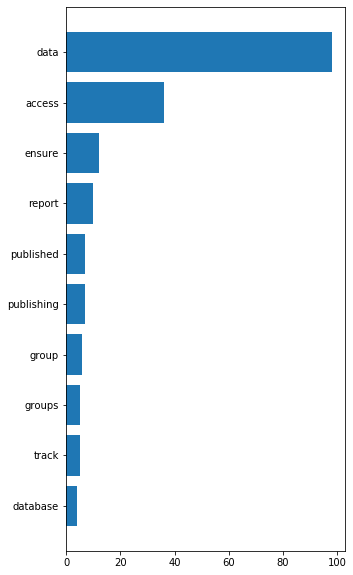

In [78]:
vect = TfidfVectorizer()

X = vect.fit_transform(bow2.lower().split(' '))

# zipping actual words and sum of their Tfidf for corpus
features_rank = list(zip(vect.get_feature_names(), [x[0] for x in X.sum(axis=0).T.tolist()]))

# sorting
features_rank = np.array(sorted(features_rank, key=lambda x:x[1], reverse=True))

n = 10
plt.figure(figsize=(5, 10))
plt.barh(-np.arange(n), features_rank[:n, 1].astype(float), height=.8)
plt.yticks(ticks=-np.arange(n), labels=features_rank[:n, 0])